# XGBoost Cluster-Aware Energy Forecasting

## 📋 Overview

This notebook demonstrates **cluster-aware energy forecasting** using XGBoost for smart meter data. The approach leverages household clustering to improve prediction accuracy by training specialized models for different consumption patterns.

### 🎯 Objectives
- Compare global vs. cluster-specific XGBoost models
- Evaluate day-ahead and week-ahead forecasting performance
- Analyze feature importance across different household clusters
- Provide comprehensive model evaluation and visualization

### 📊 Dataset
- **Source**: Smart meter energy consumption data
- **Features**: Time-based, weather, household characteristics, and engineered features
- **Clustering**: Autoencoder-based household segmentation
- **Target**: Energy consumption (kWh) for 1-day and 7-day ahead forecasting

### 🔧 Methodology
1. **Data Preparation**: Load and preprocess feature-engineered dataset
2. **Global Models**: Train XGBoost models on entire dataset
3. **Cluster-Specific Models**: Train separate models for each household cluster
4. **Evaluation**: Compare performance metrics and feature importance
5. **Visualization**: Generate plots for model interpretation


## 📦 Setup and Imports

Setting up the environment and importing necessary libraries for data processing, modeling, and visualization.


In [1]:
import sys
sys.path.append("/kaggle/input/utility-smart-meter/src")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import our enhanced modules
from data.data_loader import load_all_raw_data
from data.data_cleaner import clean_and_merge_all_data
from features.feature_pipeline import create_comprehensive_features
from features.splitters import prepare_forecasting_data, prepare_weekahead_data
from utils.helpers import reduce_memory_footprint

from models.xgboost_forecasting import (
    run_xgb_with_optuna
)

from evaluation.forecast_evaluation import (
    compute_forecast_metrics,
    print_split_summary,
    evaluate_model,
    evaluate_peak_performance,
    evaluate_forecast_residuals
)

from visualization.forecast_plots import (
    plot_feature_importance,
    plot_actual_vs_predicted,
    plot_peak_actual_vs_predicted
)

from sklearn.preprocessing import LabelEncoder


## ⚙️ Configuration

Defining the experimental configuration including:
- **Data path**: Location of the preprocessed dataset
- **Forecast scope**: Whether to train on single household, subset, or all households
- **Time horizons**: Day-ahead and/or week-ahead forecasting
- **Model parameters**: GPU usage, hyperparameter optimization trials, etc.


In [3]:
CONFIG = {
    'data_path': '/kaggle/input/smart-fl/smart_energy.parquet',
    'test_days': 90,
    'val_days': 60,
    'forecast_scope': 'subset',     # 'single', 'subset', 'all'
    'sample_household': 'MAC000001',
    'subset_households': 400,       # list or int
    'forecast_horizon': 'both',     # 'day', 'week', or 'both'
    'use_gpu': False,
    'log_transform': True,
    'n_trials': 20,
    'seed': 42,
    'week_ahead_days': 7
}


## 📊 Data Loading and Preprocessing

Loading the feature-engineered dataset and preparing it for modeling:

1. **Cluster Selection**: Using autoencoder clusters (dropping kmeans clusters)
2. **Encoding**: Label encode household IDs for XGBoost compatibility
3. **Data Types**: Convert object columns to categorical for better performance


In [8]:
# Load feature-engineered dataset
df_features = pd.read_parquet(CONFIG["data_path"])

# Drop kmeans_cluster and use only autoencoder_cluster
df_features = df_features.drop(columns=["kmeans_cluster"], errors="ignore")
df_features["autoencoder_cluster"] = df_features["autoencoder_cluster"].astype("category")

# Encode households
df_features["household_code"] = LabelEncoder().fit_transform(df_features["LCLid"])

# Fix object-type columns (e.g., Acorn, season) to be usable by XGBoost
for col in df_features.select_dtypes("object").columns:
    df_features[col] = df_features[col].astype("category")


In [5]:
# Count unique households per autoencoder cluster
cluster_household_counts = (
    df_features.groupby("autoencoder_cluster")["LCLid"]
    .nunique()
    .reset_index()
    .rename(columns={"LCLid": "Unique_Households"})
    .sort_values("autoencoder_cluster")
)
cluster_household_counts

,autoencoder_cluster,Unique_Households
0,0,5449
1,1,3821
2,2,4830
3,3,5315


## 🎯 Household Selection

Filtering households based on the configured forecast scope:
- **Single**: Focus on one specific household
- **Subset**: Random selection of households for faster experimentation
- **All**: Use entire dataset for comprehensive analysis


In [10]:

all_households = df_features["LCLid"].unique()

if CONFIG["forecast_scope"] == "single":
    # Use one specific household
    hh_filter = [CONFIG["sample_household"]]

elif CONFIG["forecast_scope"] == "subset":
    sh = CONFIG["subset_households"]

    if isinstance(sh, int):
        # Sample 'sh' households per cluster
        np.random.seed(CONFIG["seed"])
        sampled_households = (
            df_features.groupby("autoencoder_cluster")["LCLid"]
            .unique()
            .apply(lambda x: np.random.choice(x, size=min(sh, len(x)), replace=False))
            .explode()
            .dropna()
            .astype(str)
            .unique()
            .tolist()
        )
        hh_filter = sampled_households

    elif isinstance(sh, list):
        # Use explicitly provided list
        hh_filter = sh

    else:
        raise ValueError("subset_households must be int or list")

else:
    # Use all households
    hh_filter = all_households.tolist()

# Apply the filter to df_features
df_features = df_features[df_features["LCLid"].isin(hh_filter)]


# 🔮 Day-Ahead Forecasting

## 🏗️ Global Model Training

Training a single XGBoost model on all households to establish baseline performance. This global approach treats all households uniformly without considering cluster-specific patterns.


In [15]:
if CONFIG['forecast_horizon'] in ['day', 'both']:
    print("\n📊 Preparing day-ahead data...")

    train_df, val_df, test_df, feature_cols, target_col, _ = prepare_forecasting_data(
        df_features,
        target_col="total_kwh",
        test_days=CONFIG["test_days"],
        val_days=CONFIG["val_days"]
    )

    for col in ['household_code', 'autoencoder_cluster']:
        if col not in feature_cols:
            feature_cols.append(col)

    print(f"✅ Day-ahead data prepared:")
    print(f"   📈 Training samples: {len(train_df):,}")
    print(f"   🔍 Validation samples: {len(val_df):,}")
    print(f"   🎯 Test samples: {len(test_df):,}")
    print(f"   🔧 Features: {len(feature_cols)}")
    print(f"   🎯 Target: {target_col}")

    print("\n📈 Training global day-ahead model...")
    results_day = run_xgb_with_optuna(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        feature_cols=feature_cols,
        target_col="label_1",
        use_gpu=CONFIG["use_gpu"],
        log_transform=CONFIG["log_transform"],
        n_trials=CONFIG["n_trials"],
        seed=CONFIG["seed"]
    )




📊 Preparing day-ahead data...
✅ Day‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 698,042  (Households: 1429)
   ✅ Val rows:   79,281  (Households: 1342)
   ✅ Test rows:  115,665  (Households: 1314)
   ✅ Train period: 2011-11-24 to 2013-09-29
   ✅ Val period:   2013-09-30 to 2013-11-28
   ✅ Test period:  2013-11-29 to 2014-02-26
   ✅ Initial features (before static): 60
   ✅ Final features (including static): 63
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_1'
✅ Day-ahead data prepared:
   📈 Training samples: 698,042
   🔍 Validation samples: 79,281
   🎯 Test samples: 115,665
   🔧 Features: 63
   🎯 Target: label_1

📈 Training global day-ahead model...


  0%|          | 0/20 [00:00<?, ?it/s]

### 📈 Global Model Results Analysis

In [16]:
evaluate_model(results_day)


📊 OVERALL FORECAST EVALUATION
----------------------------------------
   📊 Train Performance:
      MAE:  1.6530 kWh
      RMSE: 2.8845 kWh
      MAPE: 25.39%
      R²:   0.8654
      Bias: -0.2997  (positive=overestimate, negative=underestimate)

   📊 Val Performance:
      MAE:  1.7303 kWh
      RMSE: 3.0620 kWh
      MAPE: 23.16%
      R²:   0.8539
      Bias: -0.3324  (positive=overestimate, negative=underestimate)

   📊 Test Performance:
      MAE:  2.1973 kWh
      RMSE: 4.1293 kWh
      MAPE: 24.88%
      R²:   0.8132
      Bias: -0.6569  (positive=overestimate, negative=underestimate)



In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Extract predictions and actuals
y_pred_global = results_day["predictions"]["test"]
y_true_global = results_day["actuals"]["test"]

min_len_global = min(len(test_df), len(y_pred_global), len(y_true_global))
df_eval_global = test_df.reset_index(drop=True).iloc[:min_len_global].copy()
df_eval_global["y_pred"] = y_pred_global[:min_len_global]
df_eval_global["y_true"] = y_true_global[:min_len_global]

# === Define MAPE and SMAPE functions ===

def mean_absolute_percentage_error_clipped(y_true, y_pred, threshold=0.1):
    """Avoid division by very small values for MAPE stability."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true >= threshold
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.nan

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """Stable and bounded percentage error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100 if mask.any() else np.nan

# === Evaluate by Cluster ===

def evaluate_by_cluster(df, cluster_col="autoencoder_cluster"):
    cluster_scores = []
    for cluster in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster]
        y_true = cluster_data["y_true"]
        y_pred = cluster_data["y_pred"]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        mape = mean_absolute_percentage_error_clipped(y_true, y_pred)
        smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)
        cluster_scores.append({
            "Cluster": cluster,
            "MAE": round(mae, 4),
            "RMSE": round(rmse, 4),
            "R2": round(r2, 4),
            "MAPE (%)": round(mape, 2),
            "SMAPE (%)": round(smape, 2),
            "Samples": len(cluster_data),
            "Model": "Global"
        })
    return pd.DataFrame(cluster_scores)

# === Run evaluation ===
cluster_eval_df = evaluate_by_cluster(df_eval_global)

cluster_eval_df


,Cluster,MAE,RMSE,R2,MAPE (%),SMAPE (%),Samples,Model
0,0,3.1554,5.5159,0.7877,22.12,19.90,42957,Global
1,1,0.9333,2.1171,0.2281,36.68,36.83,14411,Global
2,2,1.0258,1.8990,0.2742,21.66,19.62,18083,Global
3,3,2.1534,3.6488,0.6590,20.05,19.03,40214,Global


In [21]:
# Filter only Cluster 1 households
cluster_1_df = df_features[df_features["autoencoder_cluster"] == 1]
print(f"Cluster 1 sample size: {len(cluster_1_df):,}")


Cluster 1 sample size: 132,672


In [22]:
# Prepare train/val/test splits for Cluster 1
train_df, val_df, test_df, feature_cols, target_col, _ = prepare_forecasting_data(
    cluster_1_df,
    target_col="total_kwh",
    test_days=CONFIG["test_days"],
    val_days=CONFIG["val_days"]
)


✅ Day‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 106,769  (Households: 1036)
   ✅ Val rows:   10,829  (Households: 575)
   ✅ Test rows:  13,965  (Households: 551)
   ✅ Train period: 2011-11-24 to 2013-09-29
   ✅ Val period:   2013-09-30 to 2013-11-28
   ✅ Test period:  2013-11-29 to 2014-02-26
   ✅ Initial features (before static): 60
   ✅ Final features (including static): 63
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_1'


In [23]:
# Run XGBoost model on Cluster 1 data
results_cluster1 = run_xgb_with_optuna(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    feature_cols=feature_cols,
    target_col="label_1",
    use_gpu=CONFIG["use_gpu"],
    log_transform=CONFIG["log_transform"],
    n_trials=CONFIG["n_trials"],
    seed=CONFIG["seed"]
)


  0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === 1. Extract predictions and actuals from trained model ===
y_pred = results_cluster1["predictions"]["test"]
y_true = results_cluster1["actuals"]["test"]

# === 2. Align lengths in case of mismatch ===
min_len = min(len(test_df), len(y_pred), len(y_true))

df_eval = test_df.reset_index(drop=True).iloc[:min_len].copy()
df_eval["y_pred"] = y_pred[:min_len]
df_eval["y_true"] = y_true[:min_len]

# === 3. Define all evaluation metrics ===

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100

def evaluate_single_cluster(df):
    y_true = df["y_true"]
    y_pred = df["y_pred"]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    return pd.DataFrame([{
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "R2": round(r2, 4),
        "MAPE (%)": round(mape, 2),
        "SMAPE (%)": round(smape, 2),
        "Samples": len(df)
    }])

# === 4. Run evaluation and show results ===
cluster1_eval_df = evaluate_single_cluster(df_eval)

cluster1_eval_df

,MAE,RMSE,R2,MAPE (%),SMAPE (%),Samples
0,0.3933,0.5652,0.6444,34.62,27.12,13965


###  Cluster 2 Model

In [25]:
# Filter only Cluster 1 households
cluster_2_df = df_features[df_features["autoencoder_cluster"] == 2]
print(f"Cluster 2 sample size: {len(cluster_2_df):,}")


Cluster 2 sample size: 169,147


In [26]:
# Prepare train/val/test splits for Cluster 1
train_df, val_df, test_df, feature_cols, target_col, _ = prepare_forecasting_data(
    cluster_2_df,
    target_col="total_kwh",
    test_days=CONFIG["test_days"],
    val_days=CONFIG["val_days"]
)


✅ Day‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 136,650  (Households: 1286)
   ✅ Val rows:   13,727  (Households: 855)
   ✅ Test rows:  17,440  (Households: 779)
   ✅ Train period: 2011-11-27 to 2013-09-29
   ✅ Val period:   2013-09-30 to 2013-11-28
   ✅ Test period:  2013-11-29 to 2014-02-26
   ✅ Initial features (before static): 60
   ✅ Final features (including static): 63
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_1'


In [27]:
results_cluster2 = run_xgb_with_optuna(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    feature_cols=feature_cols,
    target_col="label_1",
    use_gpu=CONFIG["use_gpu"],
    log_transform=CONFIG["log_transform"],
    n_trials=CONFIG["n_trials"],
    seed=CONFIG["seed"]
)


  0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
# Extract predictions
y_pred = results_cluster2["predictions"]["test"]
y_true = results_cluster2["actuals"]["test"]

# Align lengths
min_len = min(len(test_df), len(y_pred), len(y_true))
df_eval = test_df.reset_index(drop=True).iloc[:min_len].copy()
df_eval["y_pred"] = y_pred[:min_len]
df_eval["y_true"] = y_true[:min_len]

# Run evaluation
cluster2_eval_df = evaluate_single_cluster(df_eval)
cluster2_eval_df

,MAE,RMSE,R2,MAPE (%),SMAPE (%),Samples
0,0.4581,0.6061,0.3884,10.48,10.39,17440


## 📊 Global Model Visualization

Generating comprehensive visualizations for the global model:
1. **Feature Importance**: Top 15 most important features for prediction
2. **Actual vs Predicted**: Time series comparison for sample households
3. **Peak Performance**: Analysis of model performance on high-consumption periods


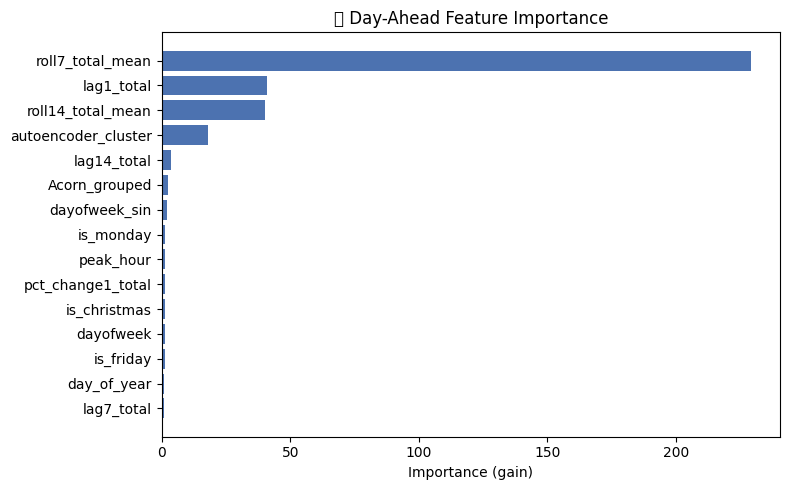

In [31]:
# Day-ahead plots
if CONFIG["forecast_horizon"] in ["day", "both"]:
    plot_feature_importance(
        xgb_model=results_day["model"],
        feature_names=feature_cols,
        top_n=15,
        importance_type="gain",
        title="Day-Ahead Feature Importance"
    )

    # plot_actual_vs_predicted(
    #     df_test=test_df,
    #     date_col="day",
    #     id_col="LCLid",
    #     target_col="label_1",
    #     y_pred=results_day["predictions"]["test"],
    #     sample_n=5,
    #     title_prefix="Day-Ahead Forecast vs Actual"
    # )

    # plot_peak_actual_vs_predicted(
    #     df_test=test_df,
    #     target_col="label_1",
    #     y_pred=results_day["predictions"]["test"],
    #     percentile=90,
    #     title="Day-Ahead Peak Performance"
    # )


## 🔍 SHAP Analysis for Global Model

**SHAP (SHapley Additive exPlanations)** provides insights into feature contributions for individual predictions.

This analysis shows:
- **Global feature importance** across all households
- **Cluster-specific patterns** in feature importance
- **Individual prediction explanations** for model interpretability


In [ ]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
# Extract test features from test_df
X_test = test_df[feature_cols].copy()

# Ensure categorical columns are label-encoded (if not already)
for col in X_test.select_dtypes("category").columns:
    X_test[col] = X_test[col].cat.codes
# Use trained model from results_day
booster = results_day["model"]

# Convert to DMatrix
dtest = xgb.DMatrix(X_test)

# SHAP Explainer
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test)
for cid in sorted(test_df["autoencoder_cluster"].unique()):
    X_cluster = X_test[test_df["autoencoder_cluster"] == cid]
    shap_vals = explainer.shap_values(X_cluster)
    print(f"🔍 SHAP Summary for Cluster {cid}")
    shap.summary_plot(shap_vals, X_cluster, plot_type="dot")


# 📅 Week-Ahead Forecasting

Moving from day-ahead to week-ahead forecasting presents additional challenges:
- **Longer horizon**: 7-day predictions are inherently more uncertain
- **Seasonal patterns**: Weekly consumption cycles become more important
- **Aggregated features**: Different feature engineering for weekly targets

## 🏗️ Global Week-Ahead Model


Training the global week-ahead XGBoost model with the same configuration as day-ahead but targeting 7-day consumption predictions.


In [32]:
from features.splitters import prepare_weekahead_data

# Prepare week-ahead data
train_df7, val_df7, test_df7, feature_cols7, target_col7, feature_groups7 = prepare_weekahead_data(
    raw_df=df_features,       # This must include total_kwh per day
    df_features=df_features,  # Feature-engineered DF
    test_days=90,
    val_days=60
)



✅ Week‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 689,518  (Households: 1429)
   ✅ Val rows:   79,275  (Households: 1342)
   ✅ Test rows:  115,615  (Households: 1314)
   ✅ Train period: 2011-11-24 to 2013-09-23
   ✅ Val period:   2013-09-24 to 2013-11-22
   ✅ Test period:  2013-11-23 to 2014-02-20
   ✅ Initial features (before static): 60
   ✅ Final features (including static): 63
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_7'


### 📊 Week-Ahead Global Model Results

**Performance Analysis:**
- **Test R²**: 0.76 - Lower than day-ahead (0.84) as expected for longer horizon
- **Test MAE**: 2.53 kWh - Higher absolute error than day-ahead
- **Peak MAPE**: 23.91% - Better percentage performance on high-consumption periods
- **Peak Bias**: -7.07 kWh - Significant underestimation of peak consumption

The model shows the expected degradation in performance for longer forecasting horizons, but maintains reasonable accuracy.


In [35]:
results_week = run_xgb_with_optuna(
    train_df=train_df7,
    val_df=val_df7,
    test_df=test_df7,
    feature_cols=feature_cols7,
    target_col=target_col7,     # "label_7"
    use_gpu=True,               # or False if needed
    log_transform=True,         # applies log1p on y
    n_trials=20,                # or fewer if you're debugging
    seed=42
)

  0%|          | 0/20 [00:00<?, ?it/s]

## 📊 Week-Ahead Visualization

Creating visualizations for the week-ahead global model:
- **Feature importance** for weekly forecasting
- **Time series plots** comparing predictions vs actual consumption


In [36]:
evaluate_model(results_week)

# Optional: Peak performance analysis (e.g., top 10% demand weeks)
evaluate_peak_performance(
    df_test=test_df7,
    target_col="label_7",
    y_pred=results_week["predictions"]["test"],
    percentile=90
)


📊 OVERALL FORECAST EVALUATION
----------------------------------------
   📊 Train Performance:
      MAE:  2.0746 kWh
      RMSE: 3.7843 kWh
      MAPE: 41.31%
      R²:   0.7687
      Bias: -0.4996  (positive=overestimate, negative=underestimate)

   📊 Val Performance:
      MAE:  2.1441 kWh
      RMSE: 4.0893 kWh
      MAPE: 33.16%
      R²:   0.7378
      Bias: -0.5649  (positive=overestimate, negative=underestimate)

   📊 Test Performance:
      MAE:  2.5816 kWh
      RMSE: 4.8568 kWh
      MAPE: 37.90%
      R²:   0.7417
      Bias: -0.5275  (positive=overestimate, negative=underestimate)


📊 Peak Performance (≥ 90th percentile → ≥ 21.6996 kWh)
   Number of peak samples: 11562
   MAE_peak:  8.4974 kWh
   RMSE_peak: 12.0952 kWh
   MAPE_peak: 24.68%
   R²_peak:   0.0782
   Bias_peak: -6.4553 kWh



{'threshold': 21.699600099999998,
 'n_samples': 11562,
 'metrics': {'mae': 8.497395587359936,
  'rmse': 12.095246105670666,
  'mape': 24.68349565817514,
  'r2': 0.07820790722438964,
  'bias': -6.455304428875612}}

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Extract predictions and actuals
y_pred_global = results_week["predictions"]["test"]
y_true_global = results_week["actuals"]["test"]

min_len_global = min(len(test_df7), len(y_pred_global), len(y_true_global))
df_eval_global = test_df7.reset_index(drop=True).iloc[:min_len_global].copy()
df_eval_global["y_pred"] = y_pred_global[:min_len_global]
df_eval_global["y_true"] = y_true_global[:min_len_global]

# === Define MAPE and SMAPE functions ===

def mean_absolute_percentage_error_clipped(y_true, y_pred, threshold=0.1):
    """Avoid division by very small values for MAPE stability."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true >= threshold
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.nan

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """Stable and bounded percentage error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100 if mask.any() else np.nan

# === Evaluate by Cluster ===

def evaluate_by_cluster(df, cluster_col="autoencoder_cluster"):
    cluster_scores = []
    for cluster in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster]
        y_true = cluster_data["y_true"]
        y_pred = cluster_data["y_pred"]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        mape = mean_absolute_percentage_error_clipped(y_true, y_pred)
        smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)
        cluster_scores.append({
            "Cluster": cluster,
            "MAE": round(mae, 4),
            "RMSE": round(rmse, 4),
            "R2": round(r2, 4),
            "MAPE (%)": round(mape, 2),
            "SMAPE (%)": round(smape, 2),
            "Samples": len(cluster_data),
            "Model": "Global"
        })
    return pd.DataFrame(cluster_scores)

# === Run evaluation ===
cluster_eval_df = evaluate_by_cluster(df_eval_global)

cluster_eval_df


,Cluster,MAE,RMSE,R2,MAPE (%),SMAPE (%),Samples,Model
0,0,3.6326,6.3758,0.7143,32.01,23.10,43136,Global
1,1,1.6379,3.8320,0.2555,58.00,45.18,14298,Global
2,2,1.2630,2.5201,0.3660,28.18,22.84,17895,Global
3,3,2.3768,4.0168,0.5943,27.91,22.18,40286,Global


In [38]:
# Filter only Cluster 1 households
cluster_1_df = df_features[df_features["autoencoder_cluster"] == 1]
print(f"Cluster 1 sample size: {len(cluster_1_df):,}")


Cluster 1 sample size: 132,672


In [50]:
# Prepare train/val/test splits for Cluster 1
train_df7, val_df7, test_df7, feature_cols7, target_col7, feature_groups7 = prepare_weekahead_data(
    raw_df=cluster_1_df,       # This must include total_kwh per day
    df_features=cluster_1_df,  # Feature-engineered DF
    test_days=90,
    val_days=60
)


✅ Week‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 103,098  (Households: 887)
   ✅ Val rows:   10,475  (Households: 452)
   ✅ Test rows:  12,070  (Households: 380)
   ✅ Train period: 2011-11-24 to 2013-09-23
   ✅ Val period:   2013-09-24 to 2013-11-22
   ✅ Test period:  2013-11-23 to 2014-02-20
   ✅ Initial features (before static): 60
   ✅ Final features (including static): 63
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_7'


In [51]:
# Run XGBoost model on Cluster 1 data
results_cluster1 = run_xgb_with_optuna(
    train_df=train_df7,
    val_df=val_df7,
    test_df=test_df7,
    feature_cols=feature_cols,
    target_col="label_7",
    use_gpu=CONFIG["use_gpu"],
    log_transform=CONFIG["log_transform"],
    n_trials=CONFIG["n_trials"],
    seed=CONFIG["seed"]
)


  0%|          | 0/20 [00:00<?, ?it/s]

In [52]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === 1. Extract predictions and actuals from trained model ===
y_pred = results_cluster1["predictions"]["test"]
y_true = results_cluster1["actuals"]["test"]

# === 2. Align lengths in case of mismatch ===
min_len = min(len(test_df7), len(y_pred), len(y_true))

df_eval = test_df7.reset_index(drop=True).iloc[:min_len].copy()
df_eval["y_pred"] = y_pred[:min_len]
df_eval["y_true"] = y_true[:min_len]

# === 3. Define all evaluation metrics ===

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100

def evaluate_single_cluster(df):
    y_true = df["y_true"]
    y_pred = df["y_pred"]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    return pd.DataFrame([{
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "R2": round(r2, 4),
        "MAPE (%)": round(mape, 2),
        "SMAPE (%)": round(smape, 2),
        "Samples": len(df)
    }])

# === 4. Run evaluation and show results ===
cluster1_eval_df = evaluate_single_cluster(df_eval)

cluster1_eval_df

,MAE,RMSE,R2,MAPE (%),SMAPE (%),Samples
0,0.4751,0.642,0.5405,57.42,33.15,12070


### Cluster 2 Model

In [44]:
# Filter only Cluster 1 households
cluster_2_df = df_features[df_features["autoencoder_cluster"] == 2]
print(f"Cluster 2 sample size: {len(cluster_2_df):,}")


Cluster 2 sample size: 169,147


In [47]:
# Prepare train/val/test splits for Cluster 1
train_df7, val_df7, test_df7, feature_cols7, target_col7, feature_groups7 = prepare_weekahead_data(
    raw_df=cluster_2_df,       # This must include total_kwh per day
    df_features=cluster_2_df,  # Feature-engineered DF
    test_days=90,
    val_days=60
)


✅ Week‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 132,461  (Households: 1163)
   ✅ Val rows:   13,225  (Households: 681)
   ✅ Test rows:  14,725  (Households: 533)
   ✅ Train period: 2011-11-27 to 2013-09-23
   ✅ Val period:   2013-09-24 to 2013-11-22
   ✅ Test period:  2013-11-23 to 2014-02-20
   ✅ Initial features (before static): 60
   ✅ Final features (including static): 63
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_7'


In [48]:
# Run XGBoost model on Cluster 2 data
results_cluster2 = run_xgb_with_optuna(
    train_df=train_df7,
    val_df=val_df7,
    test_df=test_df7,
    feature_cols=feature_cols,
    target_col="label_7",
    use_gpu=CONFIG["use_gpu"],
    log_transform=CONFIG["log_transform"],
    n_trials=CONFIG["n_trials"],
    seed=CONFIG["seed"]
)


  0%|          | 0/20 [00:00<?, ?it/s]

In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === 1. Extract predictions and actuals from trained model ===
y_pred = results_cluster2["predictions"]["test"]
y_true = results_cluster2["actuals"]["test"]

# === 2. Align lengths in case of mismatch ===
min_len = min(len(test_df7), len(y_pred), len(y_true))

df_eval = test_df7.reset_index(drop=True).iloc[:min_len].copy()
df_eval["y_pred"] = y_pred[:min_len]
df_eval["y_true"] = y_true[:min_len]

# === 3. Define all evaluation metrics ===

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100

def evaluate_single_cluster(df):
    y_true = df["y_true"]
    y_pred = df["y_pred"]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    return pd.DataFrame([{
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "R2": round(r2, 4),
        "MAPE (%)": round(mape, 2),
        "SMAPE (%)": round(smape, 2),
        "Samples": len(df)
    }])

# === 4. Run evaluation and show results ===
cluster2_eval_df = evaluate_single_cluster(df_eval)

cluster2_eval_df

,MAE,RMSE,R2,MAPE (%),SMAPE (%),Samples
0,0.4558,0.5973,0.3627,10.58,10.44,14725


## 🎯 Cluster-Specific Week-Ahead Models

Training separate week-ahead models for each household cluster to test if the cluster-aware approach also improves longer-horizon forecasting.

**Key Differences from Day-Ahead:**
- Weekly consumption patterns may be more homogeneous across clusters
- Longer horizon reduces impact of cluster-specific daily patterns
- Model complexity vs. data availability trade-off becomes more critical


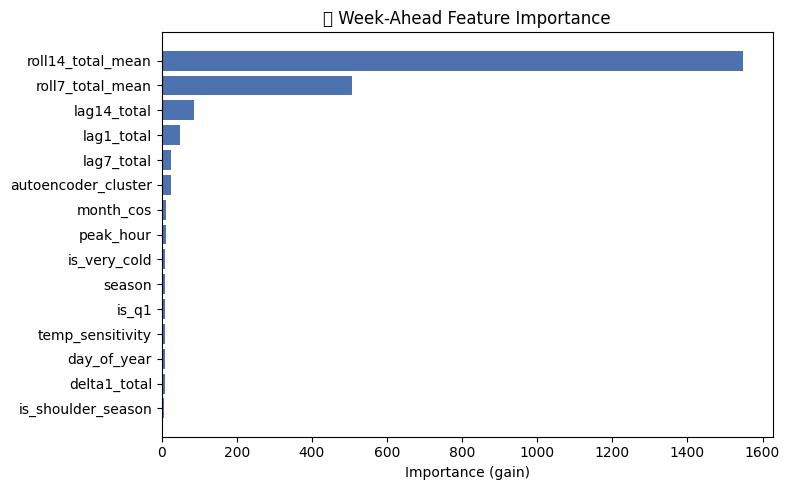

In [54]:
plot_feature_importance(
    xgb_model=results_week["model"],
    feature_names=feature_cols7,
    top_n=15,
    importance_type="gain",
    title="Week-Ahead Feature Importance"
)


